# Evasion Attack In Adversarial Robustness Toolbox (ART)

## Importing Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent
from art.utils import load_dataset
from art.defences.trainer import AdversarialTrainer
import warnings
warnings.filterwarnings("ignore")

tf.compat.v1.disable_eager_execution()

c:\Users\USER\miniconda3\envs\tf\lib\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


## Enable GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [3]:
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

## Load the data

In [4]:
(train_images, train_labels), (test_images,
                               test_labels), min_, max_ = load_dataset(name="mnist")

## Train the model

In [5]:
# Function for creating model
def make_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),        
        layers.Dense(1024 , activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

Wrapping our model with the ART KerasClassifier

In [6]:
original_model = make_model()
original_classifier = KerasClassifier(clip_values=(min_, max_), model=original_model, use_logits=False)

In [7]:
original_classifier.fit( x=train_images, y=train_labels, nb_epochs=10, batch_size=128)

In [8]:
original_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 1024)              1

## Save the model

In [9]:
original_classifier.model.save("original_model.h5")

## Evaluate on original test data

In [10]:
test_images_pred = np.argmax(original_classifier.predict(test_images), axis=1)
correct_pred_num = np.sum(test_images_pred == np.argmax(test_labels, axis=1))

print("Original test data:")
print("Correctly classified: {}".format(correct_pred_num))
print("Incorrectly classified: {}".format(len(test_images)-correct_pred_num))
print("Accuracy: {}%".format(correct_pred_num/len(test_images)*100))

Original test data:
Correctly classified: 9920
Incorrectly classified: 80
Accuracy: 99.2%


## Define the evasion attack

Defining the attack

In [11]:
attack = FastGradientMethod(
    estimator=original_classifier, 
    eps=0.3
    )

Generate adversarial samples

In [12]:
test_images_adv = attack.generate(x=test_images, y=test_labels)

## Visualize the attack

(-0.5, 27.5, 27.5, -0.5)

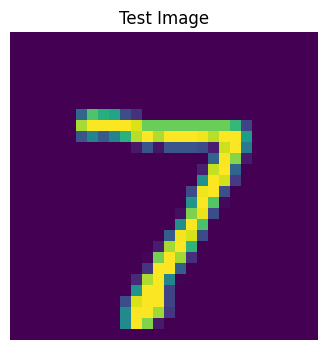

In [13]:
plt.figure(figsize=(4, 4))
plt.title("Test Image")
plt.imshow(test_images[0].squeeze())
plt.axis("off")

(-0.5, 27.5, 27.5, -0.5)

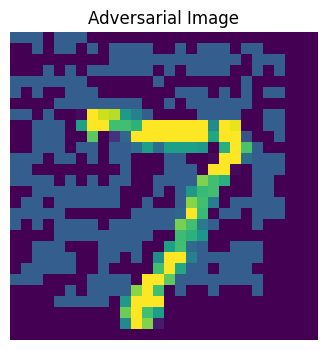

In [14]:
plt.figure(figsize=(4, 4))
plt.title("Adversarial Image")
plt.imshow(test_images_adv[0].squeeze())
plt.axis("off")

## Evaluate the attack

In [15]:
score_clean = original_model.evaluate(test_images, test_labels)
score_adv = original_model.evaluate(test_images_adv, test_labels)

In [16]:
print("Original model accuracy on original data:", score_clean[1] * 100 , "%")
print("Original model accuracy on adversarial data:", score_adv[1] * 100 , "%")

Original model accuracy on original data: 99.19999837875366 %
Original model accuracy on adversarial data: 27.730000019073486 %


## Test the accuracy of the model with different attacks strengths

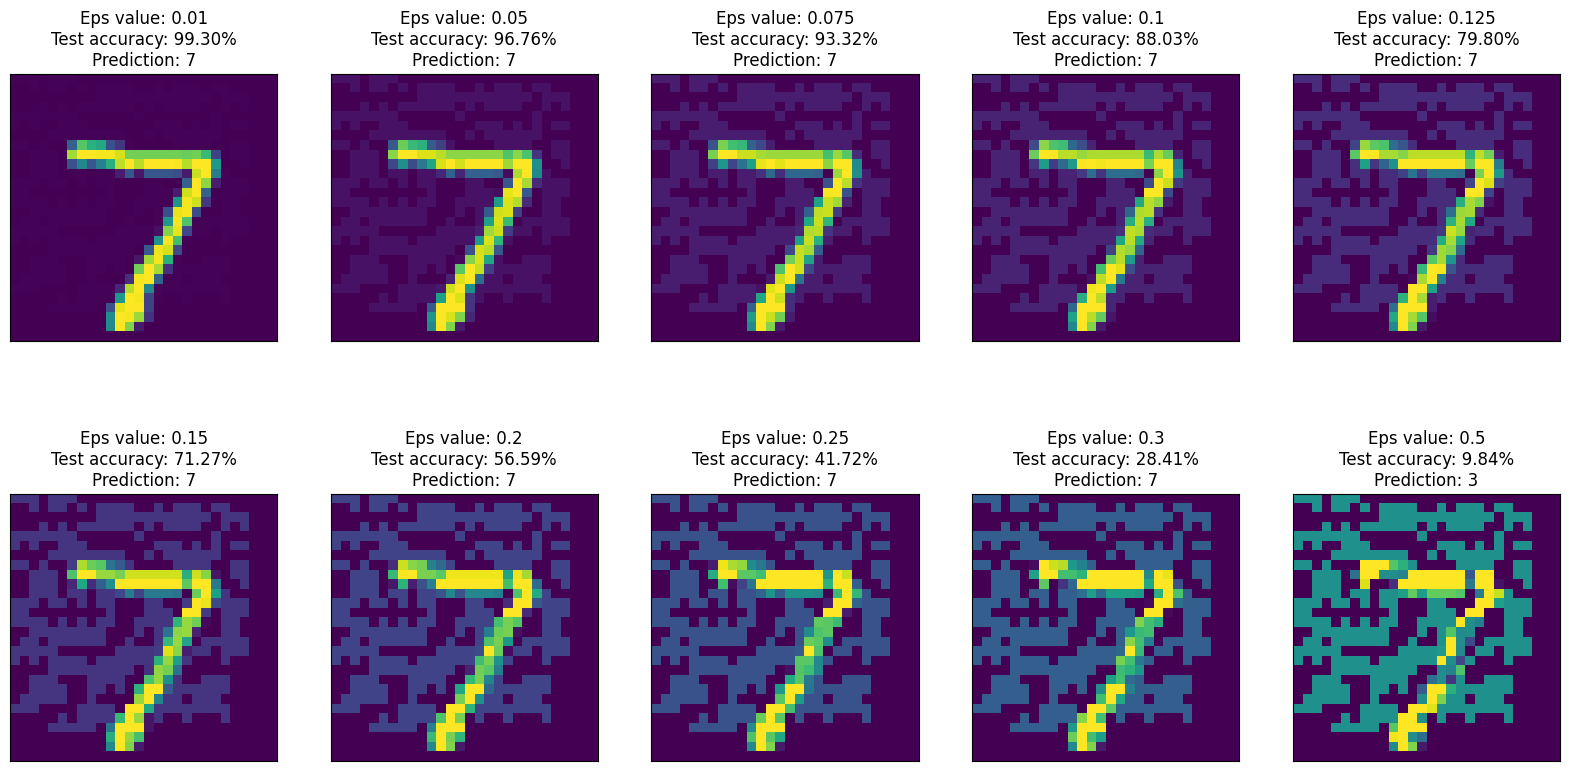

In [17]:
nrows, ncols = 2, 5

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 10)
)

# Defining a range of eps values to try
eps_to_try = [0.01, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.5]

# Defining a counting variable to traverse eps_to_try
counter = 0

for i in range(nrows):
    for j in range(ncols):
        # Creating an attack object for the current value of eps
        attack = FastGradientMethod(
            estimator=original_classifier,
            eps=eps_to_try[counter]
        )

        # Generating adversarial images
        test_images_adv = attack.generate(x=test_images)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0].squeeze())

        # Removing axes
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and get the test accuracy
        test_score = original_classifier._model.evaluate(
            x=test_images_adv,
            y=test_labels,
        )[1]

        # Getting prediction label for the image that we displayed
        prediction = np.argmax(original_model.predict(
            x=np.expand_dims(a=test_images_adv[0],
                             axis=0)
        ))

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
        )

        counter += 1

plt.show()

---

# Evasion Defense In Adversarial Robustness Toolbox (ART)

### Save the classifier and model with new names to compare at the end

In [18]:
robust_model = make_model()
robust_classifier = KerasClassifier(clip_values=(min_, max_), model=robust_model, use_logits=False)

In [19]:
robust_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)             

## Train the model with ART on expected attacks

In [20]:
expected_attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.1, max_iter=40)

In [21]:
trainer = AdversarialTrainer(robust_classifier, expected_attacks, ratio=1.0)
trainer.fit(train_images, train_labels, batch_size=128, nb_epochs=10)
robust_classifier = trainer.classifier

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

## Save the robust model

In [30]:
robust_classifier.model.save('robust_classifier.h5')

## Evaluate the robust model 

with the normal test data

In [23]:
test_images_pred_robust = np.argmax(original_classifier.predict(test_images), axis=1)
correct_pred_robust_num = np.sum(test_images_pred_robust == np.argmax(test_labels, axis=1))

print("Original test data:")
print('Correctly classified original test examples: {}'.format(correct_pred_robust_num))
print('Incorrectly classified original test examples: {}'.format(len(test_images) - correct_pred_robust_num))
print('Accuracy on original test examples: {}%'.format(correct_pred_robust_num / len(test_images) * 100))

Original test data:
Correctly classified original test examples: 9920
Incorrectly classified original test examples: 80
Accuracy on original test examples: 99.2%


with the adversarial test data and a strong attack `0.5`

In [24]:
attack = FastGradientMethod(robust_classifier, eps=0.5)
test_images_adv = attack.generate(test_images)

In [25]:
test_images_adv_pred_robust = np.argmax(robust_classifier.predict(test_images_adv), axis=1)
correct_pred_adv_robust = np.sum(test_images_adv_pred_robust == np.argmax(test_labels, axis=1))

print("Adversarial test data:")
print('Correctly classified adversarial test examples: {}'.format(correct_pred_adv_robust))
print('Incorrectly classified adversarial test examples: {}'.format(len(test_images) - correct_pred_adv_robust))
print('Accuracy on adversarial test examples: {}%'.format(correct_pred_adv_robust / len(test_images) * 100))

Adversarial test data:
Correctly classified adversarial test examples: 6956
Incorrectly classified adversarial test examples: 3044
Accuracy on adversarial test examples: 69.56%


In [26]:
attacker_pgd = ProjectedGradientDescent(estimator=original_classifier, eps=0.5, eps_step=0.01, max_iter=200, verbose=False)
attacker_robust_pgd = ProjectedGradientDescent(estimator=robust_classifier, eps=0.5, eps_step=0.01, max_iter=200, verbose=False)

In [27]:
eps_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
nb_correct_original = []
nb_correct_robust = []

nb_samples = 100

for eps in eps_range:
    attacker_pgd.set_params(**{'eps': eps})
    attacker_robust_pgd.set_params(**{'eps': eps})
    test_images_adv = attacker_pgd.generate(test_images[:nb_samples], test_labels[:nb_samples])
    test_images_adv_robust = attacker_robust_pgd.generate(test_images[:nb_samples], test_labels[:nb_samples])
    
    test_images_adv_pred = np.argmax(original_classifier.predict(test_images_adv), axis=1)
    nb_correct_original += [np.sum(test_images_adv_pred == np.argmax(test_labels[:nb_samples], axis=1)) / nb_samples]
    
    test_images_adv_robust_pred = np.argmax(robust_classifier.predict(test_images_adv_robust), axis=1)
    nb_correct_robust += [np.sum(test_images_adv_robust_pred == np.argmax(test_labels[:nb_samples], axis=1)) / nb_samples]

eps_range = [0] + eps_range
nb_correct_original = [correct_pred_num / 10000] + nb_correct_original
nb_correct_robust = [correct_pred_robust_num / 10000] + nb_correct_robust

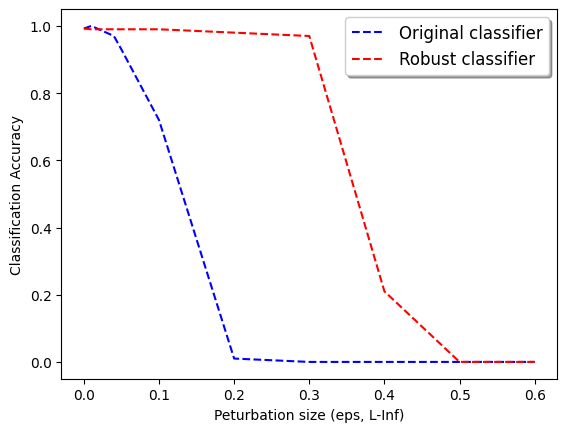

In [28]:
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Original classifier')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Robust classifier')

legend = ax.legend(loc='upper right', shadow=True, fontsize='large')

plt.xlabel('Peturbation size (eps, L-Inf)')
plt.ylabel('Classification Accuracy')
plt.show()